<span style = "width:950px; height:400px;display:inline-block;overflow:hidden;position:relative;"><img src="http://www.thebluediamondgallery.com/typewriter/images/salary.jpg" style="left: -100px;top:-500px;" /></span>

<h1> Przewidywanie przekroczenia progu dochodowego </h1><br>
Cel zadania: przewidzenie które osoby z próbki testowej mają przypisaną decyzję 1 (która oznacza, że roczne zarobki przekroczyły pewien ustalony próg). Projekt będzie oceniany na podstawie miary accuracy.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

<h2>Ściągamy dane</h2> <br>
Zbiór pochodzi  z zasobów Wydziału Matematyki, Informatyki i Mechaniki Uniwersytetu Warszawskiego. 

In [2]:
DATA_TRAIN = pd.read_csv('https://www.mimuw.edu.pl/~wswieb/proj1/z2/train.csv')
DATA_TEST = pd.read_csv('https://www.mimuw.edu.pl/~wswieb/proj1/z2/test.csv')
DATA_TRAIN.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,dec
18195,42,C,169383,K,14,A,F,C,A,B,0,0,40,A,1
14695,38,A,354591,D,9,C,C,F,E,A,114,0,38,A,0
5407,38,C,284166,E,15,C,F,D,A,B,0,0,50,A,0
15332,29,C,358124,D,9,C,C,E,E,A,0,0,52,A,0
10508,28,E,299249,D,9,B,M,D,A,A,0,0,40,A,0


<h2> Patrzymy na liczbę rekordów i stosunek liczby zmiennych do rekordów </h2><br> Zarówno zbyt mało jak i zbyt dużo kolumn w stosunku do wierszy może zaszkodzic naszemu modelowi.

In [3]:
DATA_TRAIN.shape

(32562, 15)

<h2> Patrzymy na podstawowe informacje oraz statystki opisowe dotyczące naszych zmiennych </h2> <br>
Zauważmy, że nasz zmienne cechują się różnym zakresem oraz zmiennością. Dobrym pomysłem byłaby więc ich standaryzacja. 

In [4]:
DATA_TRAIN.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,dec
count,32562.000000,3.256200e+04,32562.000000,32562.000000,32562.000000,32562.000000,32562.000000
mean,38.629353,1.899501e+05,10.066366,1084.449911,83.873257,40.407192,0.236779
std,13.723775,1.063772e+05,2.580824,7495.720474,395.966714,12.406439,0.425112
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176060e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783220e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.375425e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


<h2>Patrzymy czy nasza kolumna decyzyjna jest zbalansowana </h2> <br> 
Informacja ta może nam się to przydać np przy wyborze progu odcięcia, jak również wyboru miary oceny jakości modelu. <br>
Ponieważ jednym z założeń projektu jest maksymalizacja miary accuracy, nie będziemy stosować innych metryk (F1-score, precision, recall etc.). <br> 
Odsetek pozytywnej oraz negatywnej decyzji wynosi 76,4% oraz 23,6% odpowiednio. Nie występuje problem skrajnego niezbalansowania danych.

In [5]:
DATA_TRAIN['dec'].value_counts()

0    24852
1     7710
Name: dec, dtype: int64

<h2> Patrzymy na braki w danych </h2> <br> Przeanalizujmy w jakich ilościach, kolumnach oraz z jakimi typami zmiennych występują, aby wymyśleć odpowiednią strategię ich imputacji. <br> 
Widzimy, że braki występują tylko w trzech kolumnach, wszystkie z tych kolumn są zmiennymi kategorycznymi. Braki danych występują  tam równie często jak inne kategorie, potraktujemy je więc jak jeszcze jedną kategorie. 

In [6]:
for x in DATA_TRAIN.columns:
    print(x)
    print( DATA_TRAIN[x].value_counts())

age
36    922
33    918
35    905
23    879
31    877
37    861
32    852
28    849
30    843
34    840
38    840
29    827
24    825
39    820
41    816
27    802
22    800
40    798
42    791
25    781
26    753
20    753
45    739
21    729
43    720
47    711
46    701
19    699
44    677
48    591
     ... 
61    277
62    260
64    237
63    232
65    171
67    158
66    157
68    133
69     99
72     84
70     84
71     82
73     78
74     55
75     49
76     45
90     35
77     33
80     27
81     26
78     21
79     21
82     10
84      9
83      7
88      4
85      3
87      3
89      2
86      1
Name: age, Length: 74, dtype: int64
workclass
C    22506
B     2613
E     2120
?     1883
A     1352
F     1107
D      963
G       15
H        3
Name: workclass, dtype: int64
fnlwgt
126569    15
125892    14
186934    13
126675    13
203488    13
99185     13
190290    12
174789    12
155489    12
120277    11
136986    11
113364    11
123429    11
164190    11
107302    11
144778   

<h2> Izolujemy zmienną celu </h2>

In [7]:
DEC = DATA_TRAIN['dec']
del DATA_TRAIN['dec']

<h2>Fragment ten zawiera algorytm inżynierii cech, który ma na celu utworzenie dodatkowych zmiennych do modelu <br> </h2>
Ponieważ w danych mamy dużo zmiennych kategorycznych, z których niektóre kategorie występują bardzo rzadko (np. tylko 3 razy), spróbujemy wybrać z każdej kolumny ze zmiennymi kategorycznymi 3 kategorie, która najbardziej różnicują nasz zbiór, pozostałe kategorie przekształcimy w jedną kategorie. Posłużymy się w tym celu płytkim drzewem decyzyjnym (o 3 wierzchołkach). Każdą kolumne ze zmiennymi kategorycznymi przepuścimy przez drzewo decyzyjne, a następnie sprawdzimy które z kategorii zostały użyte do decyzji. Otrzymane kategorie zakodujemy jako zmienne binarne. 

In [8]:
clf5 = DecisionTreeClassifier(max_depth=3)

In [9]:
le = LabelEncoder()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(DATA_TRAIN, DEC, test_size=0.1, random_state=0)
important_features = {}
features_to_save = {}
to_drop = []
for x in x_train.columns:
    best = []
    if x not in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']:
        to_drop.append(x)
        DATA_TRAIN1 = DATA_TRAIN[x]
        le = LabelEncoder()
        class_vector = le.fit_transform(DATA_TRAIN1);
        ohe = OneHotEncoder(sparse=False, categories='auto')
        one_hot = ohe.fit_transform(class_vector.reshape(len(class_vector), 1));
        DATA_TRAIN1 =  one_hot
        x_train1, x_test1, y_train, y_test = train_test_split(DATA_TRAIN1, DEC, test_size=0.1, random_state=0)
        clf5.fit(x_train1, y_train)
        clf_result = clf5.predict(x_test1)
        clf_accuracy = accuracy_score(y_test, clf_result)
        my_dict = dict(zip(le.classes_, range(len(le.classes_))))
        features_to_save[x] = clf5.feature_importances_
        for i in range(len(clf5.feature_importances_)):
            if clf5.feature_importances_[i] != 0:
                DATA_TRAIN[x + '_' + str(i)] = one_hot[:, i]   
                for n in my_dict: 
                    if i == my_dict[n]:
                        best.append(n)
        important_features[x] = best


In [11]:
DATA_TRAIN.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,relationship_0,relationship_2,relationship_3,race_2,race_3,race_4,sex_1,native-country_7,native-country_23,native-country_36
20876,19,?,48393,B,10,C,?,B,A,B,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17792,38,C,136931,F,12,C,I,D,B,A,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27113,44,C,230684,A,13,A,E,C,A,B,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30243,33,C,178615,F,12,A,B,C,A,B,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5771,19,?,264228,B,10,C,?,B,A,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2> Usuwany oryginalne zmienne </h2>

In [12]:
print(to_drop)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [13]:
DATA_TRAIN.drop(to_drop, axis=1, inplace=True)

<h2> W wyniku naszej procedury otrzymaliśmy 28 zmiennych </h2>

In [14]:
DATA_TRAIN.sample(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_0,workclass_3,workclass_6,education_0,...,relationship_0,relationship_2,relationship_3,race_2,race_3,race_4,sex_1,native-country_7,native-country_23,native-country_36
3779,31,298995,9,0,0,35,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4921,90,227796,14,20051,0,60,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8234,51,120781,15,99999,0,70,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2446,90,90523,9,0,0,99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23234,42,208068,13,7298,0,40,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


<h2> Teraz robimy wykresy dla naszych zmiennych ciągłych </h2>

Na osi x znajdują się unikalne wartości naszych zmiennych. Na osi y znajduje się procent obserwacji o zadanej wartości zmiennej celu oraz zmiennej decyzyjnej równej 1.

In [15]:
def plotsy(x):
    my_tab = pd.crosstab(index=x, 
                         columns=DEC)
    my_tab = my_tab[my_tab[0]+my_tab[1]]
    plt.plot(my_tab.index,
             my_tab[1]/(my_tab[0]))
    print (ind)
    plt.show()

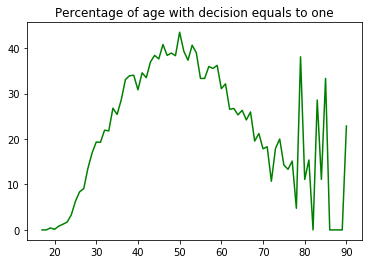

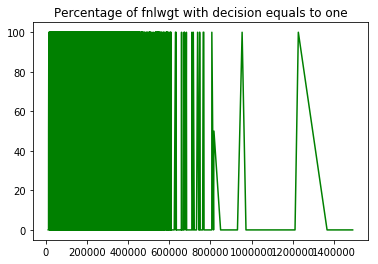

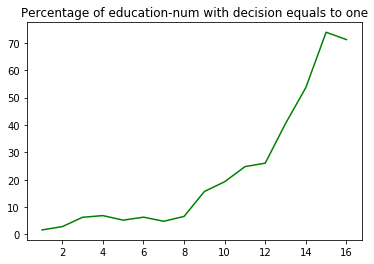

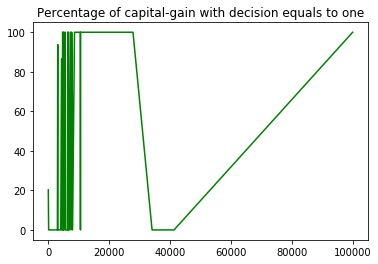

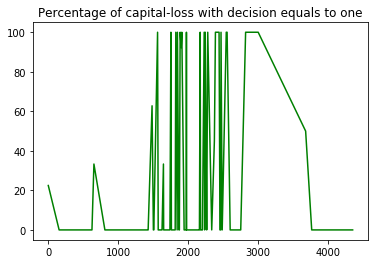

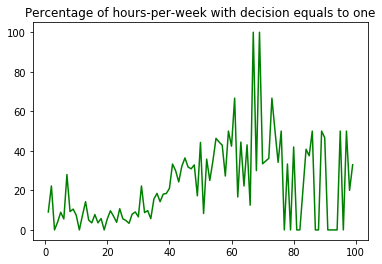

In [16]:
for ind in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']:
    my_tab = pd.crosstab(index= DATA_TRAIN[ind], columns=DEC)
    w = (my_tab[0] + my_tab[1])
    plt.plot(my_tab.index, 
             (my_tab[1]/w * 100),
             color='green')
    plt.title(' '.join(('Percentage of', ind, 'with decision equals to one')))
    plt.show()


<h2> Wykres dla education-num przypomina e^x </h2> <br>
Spróbujmy więc zlogarytmować tę zmienną.

In [17]:
DATA_TRAIN['education-num'] = np.log(DATA_TRAIN['education-num'])

In [18]:
DATA_TRAIN = DATA_TRAIN.astype('float64')

<h2> Dzielimy dane na zbiór treningowy(90%) i testowy(10%)</h2> <br>
Ustawiamy ziarno losowania, aby można było odtworzyć wyniki analizy.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(DATA_TRAIN, DEC, test_size=0.1, random_state=0)

<h2> Normalizujemy nasze zmienne </h2> <br>
Jest to przydatne przy wielu modelach takich jak svm,  KNN czy sieć neuronowa. Normalizacje dopasowywujemy najpierw do zbioru treningowego, a potem z gotowym juz parametrami normalizujemy zbiór testowy.

In [20]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

<h2> Zaczynając od najprostszych modeli patrzymy jaki wynik da nam KNN </h2> <br>
Sprawdzamy dokładność KNN z liczbą sąsiadów pochodzącymi z ciągu Fibonacciego.
Wyniki pokazują, że najlepszej liczbu sąsiadów powinniśmy szukać w przedziale 20-50.

In [21]:
x_test.dtype

dtype('float64')

In [22]:
def best_N():
    best_n = 0
    i = 1
    j = 1
    acc_glob = []
    num_neigh_glob = []
    while i < DATA_TRAIN.shape[0] // 10 and j < DATA_TRAIN.shape[0]  :
        kf = KFold(n_splits=10)
        acc = []
        num_neigh = []
        for train, test in kf.split(x_train):
            x_fold_train, x_fold_test, y_fold_train, y_fold_test = \
            pd.DataFrame(x_train).iloc[train], pd.DataFrame(x_train).iloc[test], \
            pd.Series(y_train).iloc[train], pd.Series(y_train).iloc[test]
            neigh = KNeighborsClassifier(n_neighbors=i, weights = 'distance')
            neigh.fit(x_fold_train, y_fold_train)
            predictions = neigh.predict(x_fold_test)
            b = accuracy_score(y_fold_test, predictions)
            acc.append(b)
            
        print(str(round((sum(acc) / len(acc)) * 100, 4)), '%' ,\
        'accuracy with ' , i , 'neighbours')
        num_neigh_glob.append(i)
        acc_glob.append((sum(acc) / len(acc)) * 100)
        k = i
        i = i + j 
        j = k   
    return acc_glob, num_neigh_glob


In [23]:
acc_glob, num_neigh_glob = best_N()

79.8841 % accuracy with  1 neighbours
79.8909 % accuracy with  2 neighbours
81.5765 % accuracy with  3 neighbours
82.2999 % accuracy with  5 neighbours
82.8322 % accuracy with  8 neighbours
83.1871 % accuracy with  13 neighbours
83.4021 % accuracy with  21 neighbours
83.6376 % accuracy with  34 neighbours
83.5455 % accuracy with  55 neighbours
83.5079 % accuracy with  89 neighbours
83.3237 % accuracy with  144 neighbours
83.1872 % accuracy with  233 neighbours
83.1496 % accuracy with  377 neighbours
83.2349 % accuracy with  610 neighbours
83.0438 % accuracy with  987 neighbours
82.1361 % accuracy with  1597 neighbours
80.8736 % accuracy with  2584 neighbours


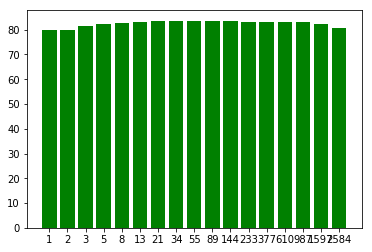

In [24]:
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14,15,16], 
        acc_glob,
        color='green'
       )
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
           (num_neigh_glob))
plt.show()

<h2> Trenujemy las losowy</h2> <br>
Dopasowujemy parametry za pomocą przeszukiwania po kracie. 

In [25]:
parameters = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1, 5, 10, 15]
    }
rfc = RandomForestClassifier()
clf1 = GridSearchCV(rfc, 
                    parameters,
                    verbose=1,
                    cv=5)
clf1.fit(x_train, y_train)
clf1_result = clf1.predict(x_test)
clf1_accuracy = accuracy_score(y_test, clf1_result)
clf1_accuracy

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.4min finished


0.8652133865520417

<h2> Trenujemy klasyfikator XGBoost. </h2> <br>
Do wyszukania najlepszych parametrów również uzyjemy przeszukiwania po kracie. 

In [26]:
params1 = {
        'min_child_weight': [1, 10],
        'gamma': [ 1,  5],
        'subsample': [0,1 ,0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [5, 20, 30],
        'random_state': [0]
        }

xgb_clf = xgb.XGBClassifier()
clf2 = GridSearchCV(xgb_clf, 
                    params1,
                    cv=2)
clf2.fit(x_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [1, 10], 'gamma': [1, 5], 'subsample': [0, 1, 0.6, 1.0], 'colsample_bytree': [0.6, 1.0], 'max_depth': [5, 20, 30], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

<h2> Odtwarzamy pipeline na zbiorze testowym <h2>

In [27]:
clf2.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 1,
 'random_state': 0,
 'subsample': 1}

In [28]:
clf_knn = KNeighborsClassifier(n_neighbors=34, weights = 'distance')
clf_knn.fit(x_train, y_train)
clf_knn_result = clf_knn.predict(x_test)
clf_knn_accuracy = accuracy_score(y_test, clf_knn_result)
clf_knn_accuracy

0.8431071538225361

In [29]:
clf1_result = clf1.predict(x_test)
clf1_accuracy = accuracy_score(y_test, clf1_result)
clf1_accuracy

0.8652133865520417

In [30]:
clf2_result = clf2.predict(x_test)
clf2_accuracy = accuracy_score(y_test, clf2_result)
clf2_accuracy

0.8722750997850783

<h2> Dokładność ok. 87% jest najlepsza spośród wszystkich uzyskanych przez nas na danych z tego zadania. </h2> <br>
Użyjemy więc XGBoosta z znalezionymi poprzez GridSearch parametrami do przewidzenia naszego zbioru testowego. Odtwarzamy pipeline dla nowych danych i zapisujemy prognozy w postaci pliku tekstowego.

In [31]:
to_drop1 = []
for x in DATA_TEST.columns:
    if x not in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']:
        to_drop1.append(x)
        DATA_TEST1 = DATA_TEST[x]
        le = LabelEncoder()
        class_vector = le.fit_transform(DATA_TEST1);
        ohe = OneHotEncoder(sparse=False, categories='auto')
        one_hot = ohe.fit_transform(class_vector.reshape(len(class_vector), 1));
        DATA_TEST1 =  one_hot
        a = features_to_save[x]
        for i in range(len(a)):
            if a[i] != 0:
                DATA_TEST[x + '_' + str(i)] = one_hot[:, i]


In [32]:
DATA_TEST.drop(to_drop1, axis=1, inplace=True)

In [33]:
DATA_TEST.shape

(16280, 28)

In [34]:
DATA_TEST = DATA_TEST.astype('float64')
DATA_TEST = scaler.transform(DATA_TEST)

In [35]:
RESULT = clf2.predict(DATA_TEST)

In [36]:
np.savetxt('zadanie2_wyniki.txt', RESULT, delimiter=',') 